In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_excel("../SMART Banking data_4035.xlsx")

In [3]:
customer_data = data.copy(deep=True)
customer_data.columns = customer_data.iloc[0]
customer_data = customer_data[1:]
customer_data.reset_index(drop=True, inplace=True)
customer_data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,estimated_salary
0,1563462,619,France,Female,42,2,NaN,11348.88
1,15647311,68,Spain,Female,41,1,8387.86,112542.58
2,1561934,52,France,Female,42,8,15966.8,113931.57
3,1571354,699,France,Female,39,1,NaN,93826.63
4,15737888,85,Spain,Female,43,2,12551.82,7984.1


In [4]:
from scipy.stats import shapiro

stat, p = shapiro(customer_data['balance'].dropna())
print('Shapiro-Wilk test: stat=%.3f, p=%.3f' % (stat, p))

if p > 0.05:
    print('Probably normal')
else:
    print('Probably not normal')


Shapiro-Wilk test: stat=0.082, p=0.000
Probably not normal


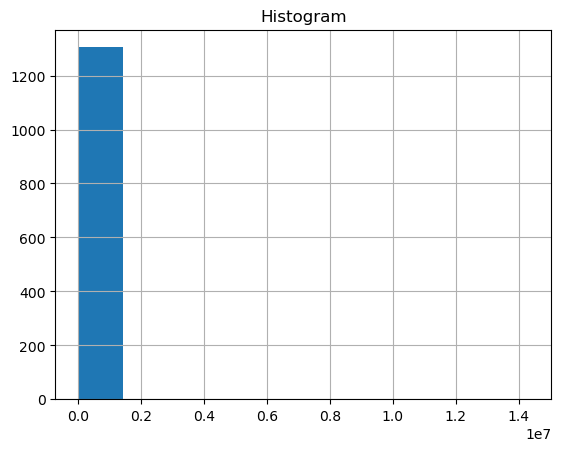

In [7]:
import matplotlib.pyplot as plt
customer_data['balance'] = customer_data['balance'].dropna()

customer_data['balance'].hist()
plt.title('Histogram')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Gradient Boosting Libraries
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# --- 1. Generate Sample Data (Replace with your actual finance dataset) ---
# For a real scenario, load your data using pd.read_csv(), etc.
np.random.seed(42)
n_samples = 1000

# Features
age = np.random.randint(20, 70, n_samples)
income = np.random.normal(50000, 15000, n_samples)
loan_amount = np.random.normal(20000, 10000, n_samples)
num_credit_cards = np.random.randint(0, 6, n_samples)
education = np.random.choice(['High School', 'Bachelors', 'Masters', 'PhD'], n_samples)
loan_status = np.random.choice(['Paid', 'Default'], n_samples, p=[0.8, 0.2])

# Target: Credit Score (simplified formula for demonstration)
# Credit score influenced by income, age, lower loan amount, education, and loan status
credit_score = (
    100 + (income / 1000) * 0.5
    + age * 2
    - (loan_amount / 1000) * 0.8
    + num_credit_cards * 5
    + np.where(education == 'PhD', 30, np.where(education == 'Masters', 20, np.where(education == 'Bachelors', 10, 0)))
    - np.where(loan_status == 'Default', 50, 0)
    + np.random.normal(0, 10, n_samples) # Add some noise
)
# Ensure credit scores are within a realistic range (e.g., 300-850)
credit_score = np.clip(credit_score, 300, 850)

data = pd.DataFrame({
    'Age': age,
    'Income': income,
    'LoanAmount': loan_amount,
    'NumCreditCards': num_credit_cards,
    'Education': education,
    'LoanStatus': loan_status,
    'CreditScore': credit_score
})

X = data.drop('CreditScore', axis=1)
y = data['CreditScore']

# --- 2. Preprocessing Pipeline ---

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- 3. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print("\n")

# --- 4. Define and Evaluate Models ---

# Function to evaluate a model
def evaluate_model(model, X_train_processed, y_train, X_test_processed, y_test, model_name="Model"):
    print(f"--- Evaluating {model_name} ---")
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R-squared: {r2:.4f}")
    print("\n")
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

# --- XGBoost Regressor ---
# Default parameters, you would tune these using GridSearchCV or RandomizedSearchCV
# For XGBoost, it's common to use the DMatrix for performance, but Pipeline handles it.
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=100,
                                 learning_rate=0.1,
                                 random_state=42,
                                 n_jobs=-1) # Use all available cores

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', xgb_regressor)])
xgb_metrics = evaluate_model(xgb_pipeline, X_train, y_train, X_test, y_test, "XGBoost Regressor")


# --- LightGBM Regressor ---
# Default parameters
lgb_regressor = lgb.LGBMRegressor(objective='regression',
                                  n_estimators=100,
                                  learning_rate=0.1,
                                  random_state=42,
                                  n_jobs=-1)

lgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', lgb_regressor)])
lgb_metrics = evaluate_model(lgb_pipeline, X_train, y_train, X_test, y_test, "LightGBM Regressor")


# --- CatBoost Regressor ---
# Default parameters. CatBoost can handle categorical features directly,
# but using OneHotEncoder in the pipeline works fine too.
# If you let CatBoost handle categories directly, you would pass `cat_features=categorical_features`
# to the CatBoostRegressor constructor and remove `categorical_transformer` from the preprocessor for CatBoost only.
cat_regressor = cb.CatBoostRegressor(iterations=100,
                                     learning_rate=0.1,
                                     random_seed=42,
                                     verbose=0, # Suppress training output for cleaner console
                                     allow_writing_files=False, # Prevent it from writing cache files
                                     loss_function='RMSE') # Specify loss function explicitly

cat_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', cat_regressor)])
cat_metrics = evaluate_model(cat_pipeline, X_train, y_train, X_test, y_test, "CatBoost Regressor")

# --- 5. Hyperparameter Tuning Example (using GridSearchCV for XGBoost) ---
print("--- Starting Hyperparameter Tuning for XGBoost (Example) ---")

# Define a smaller parameter grid for demonstration to save time
# In a real scenario, you'd use a more extensive grid or RandomizedSearchCV
param_grid_xgb = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

# Create a GridSearchCV object
grid_search_xgb = GridSearchCV(xgb_pipeline,
                               param_grid=param_grid_xgb,
                               cv=KFold(n_splits=5, shuffle=True, random_state=42), # 5-fold cross-validation
                               scoring='neg_mean_squared_error', # Optimize for RMSE (negative MSE)
                               n_jobs=-1, # Use all available cores
                               verbose=1)

# Fit GridSearchCV to the training data
grid_search_xgb.fit(X_train, y_train)

print(f"\nBest parameters for XGBoost: {grid_search_xgb.best_params_}")
print(f"Best cross-validation RMSE (neg_mean_squared_error): {-grid_search_xgb.best_score_:.2f}")

# Evaluate the best XGBoost model on the test set
best_xgb_pipeline = grid_search_xgb.best_estimator_
tuned_xgb_metrics = evaluate_model(best_xgb_pipeline, X_train, y_train, X_test, y_test, "Tuned XGBoost Regressor")

# --- 6. Compare Results ---
results = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost', 'Tuned XGBoost'],
    'MAE': [xgb_metrics['MAE'], lgb_metrics['MAE'], cat_metrics['MAE'], tuned_xgb_metrics['MAE']],
    'RMSE': [xgb_metrics['RMSE'], lgb_metrics['RMSE'], cat_metrics['RMSE'], tuned_xgb_metrics['RMSE']],
    'R2': [xgb_metrics['R2'], lgb_metrics['R2'], cat_metrics['R2'], tuned_xgb_metrics['R2']]
})

print("\n--- Model Comparison ---")
print(results.round(2))

# --- 7. Interpretability (Example for Tuned XGBoost) ---
# Note: Feature importance for pipeline models requires accessing the regressor inside the pipeline
print("\n--- Feature Importance (Tuned XGBoost) ---")
# Get feature names after one-hot encoding
preprocessor_trained = best_xgb_pipeline.named_steps['preprocessor']
ohe_feature_names = preprocessor_trained.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + ohe_feature_names.tolist()

# Get feature importances from the trained regressor
importances = best_xgb_pipeline.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# --- 8. Visualizations (Example for Tuned XGBoost) ---
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_tuned_xgb = best_xgb_pipeline.predict(X_test)
residuals = y_test - y_pred_tuned_xgb

plt.figure(figsize=(15, 5))

# Actual vs. Predicted Plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_tuned_xgb, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Ideal line
plt.xlabel("Actual Credit Score")
plt.ylabel("Predicted Credit Score")
plt.title("Actual vs. Predicted Credit Score (Tuned XGBoost)")
plt.grid(True, linestyle='--', alpha=0.7)

# Residuals Plot
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_tuned_xgb, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Credit Score")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals Plot (Tuned XGBoost)")
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Distribution of Residuals
plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Tuned XGBoost)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()